# Import Modules

In [1]:
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics import F1Score
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters Config

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=79,
        input_size_left_context=64,
        input_size_oov_context=20,
        input_size_right_context=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        output_size=3611,
        shuffle=True,
        lr=0.001,
        batch_first=True,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=20,
        patience=20,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device
        
hyperparams = Hyperparams()

# Prepare Feature Dataset

In [3]:
def convert_doc_to_idxs(docs, dict_vocabs):
    doc_to_idx = []
    
    for doc in docs:
        doc_to_idx.append([dict_vocabs[token] for token in doc])
        
    return np.array(doc_to_idx)

# Left context
left_context = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_with_pad.pkl", "rb")
left_context = pickle.load(left_context)
left_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_left_context.pkl", "rb")
left_context_to_idx = pickle.load(left_context_to_idx)
doc_left_context_to_idx = convert_doc_to_idxs(left_context, left_context_to_idx)

# OOV context
oov_context = open(f"../../datasets/features/{hyperparams.context_size}_context/oov_context_with_pad.pkl", "rb")
oov_context = pickle.load(oov_context)
oov_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_oov_context.pkl", "rb")
oov_context_to_idx = pickle.load(oov_context_to_idx)
doc_oov_context_to_idx = convert_doc_to_idxs(oov_context, oov_context_to_idx)

# Right context
right_context = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_with_pad.pkl", "rb")
right_context = pickle.load(right_context)
right_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_right_context.pkl", "rb")
right_context_to_idx = pickle.load(right_context_to_idx)
doc_right_context_to_idx = convert_doc_to_idxs(right_context, right_context_to_idx)

# Actual labels
labels_context = open(f"../../datasets/features/{hyperparams.context_size}_context/lables.pkl", "rb")
labels_context = pickle.load(labels_context)
labels_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/lable_vocabs.pkl", "rb")
labels_to_idx = pickle.load(labels_to_idx)
doc_labels_to_idx = convert_doc_to_idxs(labels_context, labels_to_idx).flatten()

print(f"Left context shape: {doc_left_context_to_idx.shape}")
print(f"OOV context shape: {doc_oov_context_to_idx.shape}")
print(f"Right context shape: {doc_right_context_to_idx.shape}")
print(f"Actual lable shape: {doc_labels_to_idx.shape}")

Left context shape: (16562, 71)
OOV context shape: (16562, 28)
Right context shape: (16562, 79)
Actual lable shape: (16562,)


In [4]:
# Convert to Tensor
left_contexts = torch.LongTensor(doc_left_context_to_idx)
oov_contexts = torch.LongTensor(doc_oov_context_to_idx)
right_contexts = torch.LongTensor(doc_right_context_to_idx)
actual_labels = torch.LongTensor(doc_labels_to_idx)
dataset = TensorDataset(left_contexts, oov_contexts, right_contexts, actual_labels)

# Char and Word Embedding

In [5]:
# Word Embedding
word_embeddings = Embedding.load("../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
word_embeddings.apply_expansion(DigitExpander)
word_embeddings.apply_expansion(CaseExpander)

left_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_vocabs.pkl", "rb")
left_vocabs = pickle.load(left_vocabs)

right_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_vocabs.pkl", "rb")
right_vocabs = pickle.load(right_vocabs)

left_word_embedding_dict = {left_context_to_idx[vocab] : word_embeddings[vocab] for vocab in left_vocabs}
right_word_embedding_dict = {right_context_to_idx[vocab] : word_embeddings[vocab] for vocab in right_vocabs}

# Char Embedding
char_embedding_dict = open("../../word_embeddings/chars_embedding/char_embeddings.pkl", "rb")
char_embedding_dict = pickle.load(char_embedding_dict)

# Context embedding
left_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(left_word_embedding_dict.values()))), padding_idx=left_vocabs.index("<PAD>"), freeze=True)
oov_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(char_embedding_dict.values()))), padding_idx=list(char_embedding_dict.keys()).index("PAD"), freeze=True)
right_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(right_word_embedding_dict.values()))), padding_idx=right_vocabs.index("<PAD>"), freeze=True)

# Dataloader

In [6]:
dataloader = DataLoader(dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

# Model

In [7]:
class Comick(nn.Module):
    def __init__(
        self,
        input_size_left_context=hyperparams.input_size_left_context,
        input_size_oov_context=hyperparams.input_size_oov_context,
        input_size_right_context=hyperparams.input_size_right_context,
        hidden_size=hyperparams.hidden_size,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(Comick, self).__init__()
        
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        
        self.bilstm_left_context_feature = nn.LSTM(
            input_size = self.input_size_left_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_oov_context_feature = nn.LSTM(
            input_size = self.input_size_oov_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_right_context_feature = nn.LSTM(
            input_size = self.input_size_right_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.fc = nn.Sequential(
            nn.Linear(2 * self.hidden_size, 64),
            nn.Tanh()
        )
        
        self.oov_embedding = nn.Linear(in_features=3 * 64, out_features=64)
        
        self.embedding = np.empty((output_size, 64), dtype=np.float32)
        
        self.prob = nn.Sequential(
            nn.Linear(64, self.output_size),
            nn.LogSoftmax(dim=1)
        )
                
        if init_wb_with_kaiming_normal:
            self.init_wb()
            
    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))

    def forward(
        self,
        input_left_context,
        input_oov_context,
        input_right_context,
        idxs_target,
        hidden_left_context=None,
        hidden_oov_context=None,
        hidden_right_context=None,
    ):
        # BiLSTM left, oov, and right context
        output_left_context, (hidden_left_context, memory_left_context) = self.bilstm_left_context_feature(input_left_context, hidden_left_context)
        output_oov_context, (hidden_oov_context, memory_oov_context) = self.bilstm_oov_context_feature(input_oov_context, hidden_oov_context)
        output_right_context, (hidden_right_context, memory_right_context) = self.bilstm_right_context_feature(input_right_context, hidden_right_context)
                
        # Concate hidden (forward and backward hidden BiLSTM)
        hidden_left_bidirectional = torch.cat((hidden_left_context[0], hidden_left_context[-1]), dim=1)
        hidden_oov_bidirectional = torch.cat((hidden_oov_context[0], hidden_oov_context[-1]), dim=1)
        hidden_right_bidirectional = torch.cat((hidden_right_context[0], hidden_right_context[-1]), dim=1)
        
        # Fully connected
        output_left_fc = self.fc(hidden_left_bidirectional)
        output_oov_fc = self.fc(hidden_oov_bidirectional)
        output_right_fc = self.fc(hidden_right_bidirectional)
        
        # Concate output left, oov, and right context feature
        output = torch.cat((output_left_fc, output_oov_fc, output_right_fc), dim=1)
        
        # OOV embedding
        output = self.oov_embedding(output)
                
        # save OOV embedding
        self.embedding[idxs_target.tolist()] = output.cpu().detach().numpy()
        
        # Projection OOV embedding
        prob = self.prob(output)
        
        return prob

# Model, Optimizer, Criterion, Metric, and Learning Rate Scheduler

In [8]:
model = Comick().to(hyperparams.device)
model.prob[0].requires_grad_ = False # disable gradient for projection layer
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.NLLLoss(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
metric = F1Score(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5)
model

Comick(
  (bilstm_left_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (bilstm_oov_context_feature): LSTM(20, 128, batch_first=True, bidirectional=True)
  (bilstm_right_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Tanh()
  )
  (oov_embedding): Linear(in_features=192, out_features=64, bias=True)
  (prob): Sequential(
    (0): Linear(in_features=64, out_features=3611, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [9]:
print(f"{sum([param.numel() for param in model.parameters() if param.requires_grad_]):,}")

814,427


In [10]:
model.embedding

array([[-4.6195900e-38,  4.5686534e-41, -4.6195900e-38, ...,
         4.5685133e-41,  1.0835681e-40,  0.0000000e+00],
       [-1.2199597e+30,  4.5685133e-41, -1.9804599e+30, ...,
         4.5685133e-41, -1.9805566e+30,  4.5685133e-41],
       [ 1.0837222e-40,  0.0000000e+00, -1.2199863e+30, ...,
         0.0000000e+00, -1.2200153e+30,  4.5685133e-41],
       ...,
       [-1.4088867e+29,  4.5685133e-41, -1.9456041e+30, ...,
         4.5685133e-41, -1.9457008e+30,  4.5685133e-41],
       [ 1.1442583e-40,  0.0000000e+00, -1.4089199e+29, ...,
         0.0000000e+00, -1.4089562e+29,  4.5685133e-41],
       [-1.9458072e+30,  4.5685133e-41,  1.1444124e-40, ...,
         4.5685133e-41,  1.1445526e-40,  0.0000000e+00]], dtype=float32)

# Training Step

In [11]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None, path_name=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (input_left_context, input_oov_context, input_right_context, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        prob = model(
            left_context_embedding(input_left_context).to(hyperparams.device),
            oov_context_embedding(input_oov_context).to(hyperparams.device),
            right_context_embedding(input_right_context).to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
                
        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
        metric_score = metric.compute()
        
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if batch % 50 == 0 or batch == len(dataloader):
            batch_name = "Batch-" + str(batch)
            print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
            with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
                f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")

        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

# Looping Step

EPOCH-1


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=4.6678 | F1Score=0.2700
Batch-100: NLLLoss=5.5524 | F1Score=0.2891
Batch-150: NLLLoss=5.4879 | F1Score=0.3125
Batch-200: NLLLoss=4.3875 | F1Score=0.3391
Batch-250: NLLLoss=4.1270 | F1Score=0.3638
Batch-300: NLLLoss=4.0027 | F1Score=0.3818
Batch-350: NLLLoss=4.4085 | F1Score=0.3981
Batch-400: NLLLoss=3.9453 | F1Score=0.4097
Batch-450: NLLLoss=4.0325 | F1Score=0.4197
Batch-500: NLLLoss=3.5535 | F1Score=0.4310
Batch-518: NLLLoss=2.7161 | F1Score=0.4342

Mean NLLLoss: 4.5361 | Mean F1Score: 0.3545

EPOCH-2


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=2.9692 | F1Score=0.5752
Batch-100: NLLLoss=2.4787 | F1Score=0.5798
Batch-150: NLLLoss=3.8593 | F1Score=0.5826
Batch-200: NLLLoss=2.3253 | F1Score=0.5913
Batch-250: NLLLoss=2.9453 | F1Score=0.6013
Batch-300: NLLLoss=2.9772 | F1Score=0.6103
Batch-350: NLLLoss=3.4423 | F1Score=0.6158
Batch-400: NLLLoss=1.6546 | F1Score=0.6233
Batch-450: NLLLoss=2.7593 | F1Score=0.6295
Batch-500: NLLLoss=3.3187 | F1Score=0.6340
Batch-518: NLLLoss=2.5120 | F1Score=0.6364

Yeah 🎉😄! Model improved.
Mean NLLLoss: 2.7052 | Mean F1Score: 0.6019

EPOCH-3


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=2.2622 | F1Score=0.7238
Batch-100: NLLLoss=2.5266 | F1Score=0.7222
Batch-150: NLLLoss=2.4284 | F1Score=0.7229
Batch-200: NLLLoss=0.7482 | F1Score=0.7269
Batch-250: NLLLoss=2.8145 | F1Score=0.7299
Batch-300: NLLLoss=2.7017 | F1Score=0.7321
Batch-350: NLLLoss=1.6597 | F1Score=0.7346
Batch-400: NLLLoss=2.4260 | F1Score=0.7378
Batch-450: NLLLoss=2.6186 | F1Score=0.7410
Batch-500: NLLLoss=1.0252 | F1Score=0.7458
Batch-518: NLLLoss=1.8554 | F1Score=0.7474

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.7794 | Mean F1Score: 0.7307

EPOCH-4


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=1.2865 | F1Score=0.8062
Batch-100: NLLLoss=1.3516 | F1Score=0.8056
Batch-150: NLLLoss=1.3854 | F1Score=0.8042
Batch-200: NLLLoss=1.8251 | F1Score=0.8078
Batch-250: NLLLoss=1.6852 | F1Score=0.8125
Batch-300: NLLLoss=0.8051 | F1Score=0.8139
Batch-350: NLLLoss=0.6391 | F1Score=0.8144
Batch-400: NLLLoss=1.0886 | F1Score=0.8160
Batch-450: NLLLoss=2.0925 | F1Score=0.8170
Batch-500: NLLLoss=1.0179 | F1Score=0.8190
Batch-518: NLLLoss=1.0733 | F1Score=0.8187

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.1521 | Mean F1Score: 0.8105

EPOCH-5


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=1.3601 | F1Score=0.8775
Batch-100: NLLLoss=0.6692 | F1Score=0.8754
Batch-150: NLLLoss=0.8687 | F1Score=0.8738
Batch-200: NLLLoss=1.9284 | F1Score=0.8746
Batch-250: NLLLoss=0.5142 | F1Score=0.8742
Batch-300: NLLLoss=1.0022 | F1Score=0.8751
Batch-350: NLLLoss=0.6435 | F1Score=0.8732
Batch-400: NLLLoss=0.6988 | F1Score=0.8749
Batch-450: NLLLoss=0.5449 | F1Score=0.8743
Batch-500: NLLLoss=0.7643 | F1Score=0.8736
Batch-518: NLLLoss=0.7497 | F1Score=0.8733

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.6849 | Mean F1Score: 0.8757

EPOCH-6


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.4915 | F1Score=0.9600
Batch-100: NLLLoss=0.3824 | F1Score=0.9581
Batch-150: NLLLoss=0.4301 | F1Score=0.9546
Batch-200: NLLLoss=0.5256 | F1Score=0.9495
Batch-250: NLLLoss=0.2498 | F1Score=0.9465
Batch-300: NLLLoss=0.3641 | F1Score=0.9467
Batch-350: NLLLoss=0.5729 | F1Score=0.9445
Batch-400: NLLLoss=0.4196 | F1Score=0.9441
Batch-450: NLLLoss=0.5113 | F1Score=0.9414
Batch-500: NLLLoss=0.6565 | F1Score=0.9393
Batch-518: NLLLoss=0.6211 | F1Score=0.9382

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.3389 | Mean F1Score: 0.9489

EPOCH-7


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.2349 | F1Score=0.9887
Batch-100: NLLLoss=0.0432 | F1Score=0.9881
Batch-150: NLLLoss=0.0258 | F1Score=0.9890
Batch-200: NLLLoss=0.0995 | F1Score=0.9892
Batch-250: NLLLoss=0.0226 | F1Score=0.9893
Batch-300: NLLLoss=0.0501 | F1Score=0.9890
Batch-350: NLLLoss=0.0565 | F1Score=0.9883
Batch-400: NLLLoss=0.1590 | F1Score=0.9877
Batch-450: NLLLoss=0.2208 | F1Score=0.9872
Batch-500: NLLLoss=0.2222 | F1Score=0.9865
Batch-518: NLLLoss=0.4356 | F1Score=0.9859

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.1178 | Mean F1Score: 0.9885

EPOCH-8


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0383 | F1Score=0.9981
Batch-100: NLLLoss=0.0558 | F1Score=0.9972
Batch-150: NLLLoss=0.0453 | F1Score=0.9970
Batch-200: NLLLoss=0.0435 | F1Score=0.9966
Batch-250: NLLLoss=0.0218 | F1Score=0.9971
Batch-300: NLLLoss=0.0182 | F1Score=0.9974
Batch-350: NLLLoss=0.0190 | F1Score=0.9973
Batch-400: NLLLoss=0.0104 | F1Score=0.9972
Batch-450: NLLLoss=0.0254 | F1Score=0.9973
Batch-500: NLLLoss=0.0437 | F1Score=0.9973
Batch-518: NLLLoss=0.0245 | F1Score=0.9974

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0402 | Mean F1Score: 0.9972

EPOCH-9


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0113 | F1Score=0.9994
Batch-100: NLLLoss=0.0079 | F1Score=0.9994
Batch-150: NLLLoss=0.0157 | F1Score=0.9992
Batch-200: NLLLoss=0.0084 | F1Score=0.9991
Batch-250: NLLLoss=0.0075 | F1Score=0.9991
Batch-300: NLLLoss=0.0377 | F1Score=0.9992
Batch-350: NLLLoss=0.0047 | F1Score=0.9991
Batch-400: NLLLoss=0.0043 | F1Score=0.9991
Batch-450: NLLLoss=0.0143 | F1Score=0.9992
Batch-500: NLLLoss=0.0089 | F1Score=0.9992
Batch-518: NLLLoss=0.0099 | F1Score=0.9992

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0123 | Mean F1Score: 0.9992

EPOCH-10


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0103 | F1Score=0.9994
Batch-100: NLLLoss=0.0070 | F1Score=0.9997
Batch-150: NLLLoss=0.0034 | F1Score=0.9998
Batch-200: NLLLoss=0.0048 | F1Score=0.9996
Batch-250: NLLLoss=0.0039 | F1Score=0.9996
Batch-300: NLLLoss=0.0047 | F1Score=0.9996
Batch-350: NLLLoss=0.0305 | F1Score=0.9995
Batch-400: NLLLoss=0.0077 | F1Score=0.9993
Batch-450: NLLLoss=0.0092 | F1Score=0.9993
Batch-500: NLLLoss=0.0093 | F1Score=0.9993
Batch-518: NLLLoss=0.0034 | F1Score=0.9993

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0083 | Mean F1Score: 0.9995

EPOCH-11


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0038 | F1Score=0.9994
Batch-100: NLLLoss=0.0039 | F1Score=0.9997
Batch-150: NLLLoss=0.0029 | F1Score=0.9996
Batch-200: NLLLoss=0.0023 | F1Score=0.9995
Batch-250: NLLLoss=0.0028 | F1Score=0.9996
Batch-300: NLLLoss=0.0031 | F1Score=0.9996
Batch-350: NLLLoss=0.0042 | F1Score=0.9996
Batch-400: NLLLoss=0.0045 | F1Score=0.9995
Batch-450: NLLLoss=0.0076 | F1Score=0.9996
Batch-500: NLLLoss=0.0049 | F1Score=0.9995
Batch-518: NLLLoss=0.0031 | F1Score=0.9995

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0053 | Mean F1Score: 0.9996

EPOCH-12


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.1830 | F1Score=0.9981
Batch-100: NLLLoss=0.0020 | F1Score=0.9991
Batch-150: NLLLoss=0.0057 | F1Score=0.9991
Batch-200: NLLLoss=0.0021 | F1Score=0.9991
Batch-250: NLLLoss=0.0011 | F1Score=0.9992
Batch-300: NLLLoss=0.0023 | F1Score=0.9993
Batch-350: NLLLoss=0.0016 | F1Score=0.9994
Batch-400: NLLLoss=0.0024 | F1Score=0.9995
Batch-450: NLLLoss=0.0028 | F1Score=0.9995
Batch-500: NLLLoss=0.0029 | F1Score=0.9996
Batch-518: NLLLoss=0.0042 | F1Score=0.9996

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0052 | Mean F1Score: 0.9990

EPOCH-13


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0012 | F1Score=1.0000
Batch-100: NLLLoss=0.0021 | F1Score=0.9997
Batch-150: NLLLoss=0.0010 | F1Score=0.9998
Batch-200: NLLLoss=0.0023 | F1Score=0.9998
Batch-250: NLLLoss=0.0030 | F1Score=0.9999
Batch-300: NLLLoss=0.0030 | F1Score=0.9999
Batch-350: NLLLoss=0.0038 | F1Score=0.9998
Batch-400: NLLLoss=0.0010 | F1Score=0.9998
Batch-450: NLLLoss=0.0028 | F1Score=0.9997
Batch-500: NLLLoss=0.0014 | F1Score=0.9997
Batch-518: NLLLoss=0.0018 | F1Score=0.9996

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0034 | Mean F1Score: 0.9998

EPOCH-14


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0011 | F1Score=1.0000
Batch-100: NLLLoss=0.0015 | F1Score=1.0000
Batch-150: NLLLoss=0.0020 | F1Score=0.9999
Batch-200: NLLLoss=0.0038 | F1Score=0.9996
Batch-250: NLLLoss=0.0041 | F1Score=0.9993
Batch-300: NLLLoss=0.0029 | F1Score=0.9994
Batch-350: NLLLoss=0.2525 | F1Score=0.9951
Batch-400: NLLLoss=0.5604 | F1Score=0.9761
Batch-450: NLLLoss=0.8718 | F1Score=0.9625
Batch-500: NLLLoss=0.3811 | F1Score=0.9554
Batch-518: NLLLoss=0.3357 | F1Score=0.9534

Huft 😥! Model not improved.
Mean NLLLoss: 0.1817 | Mean F1Score: 0.9897
Patience = 1/20❗

EPOCH-15


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.1434 | F1Score=0.9613
Batch-100: NLLLoss=0.0387 | F1Score=0.9583
Batch-150: NLLLoss=0.1775 | F1Score=0.9599
Batch-200: NLLLoss=0.0554 | F1Score=0.9632
Batch-250: NLLLoss=0.0262 | F1Score=0.9642
Batch-300: NLLLoss=0.1364 | F1Score=0.9627
Batch-350: NLLLoss=0.0296 | F1Score=0.9646
Batch-400: NLLLoss=0.1031 | F1Score=0.9657
Batch-450: NLLLoss=0.0435 | F1Score=0.9675
Batch-500: NLLLoss=0.0051 | F1Score=0.9687
Batch-518: NLLLoss=0.3494 | F1Score=0.9688

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.1352 | Mean F1Score: 0.9632

EPOCH-16


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0040 | F1Score=0.9972
Batch-100: NLLLoss=0.0074 | F1Score=0.9970
Batch-150: NLLLoss=0.0079 | F1Score=0.9980
Batch-200: NLLLoss=0.0050 | F1Score=0.9980
Batch-250: NLLLoss=0.0100 | F1Score=0.9982
Batch-300: NLLLoss=0.0043 | F1Score=0.9982
Batch-350: NLLLoss=0.0132 | F1Score=0.9983
Batch-400: NLLLoss=0.0152 | F1Score=0.9985
Batch-450: NLLLoss=0.0066 | F1Score=0.9985
Batch-500: NLLLoss=0.0067 | F1Score=0.9986
Batch-518: NLLLoss=0.0023 | F1Score=0.9986

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0101 | Mean F1Score: 0.9979

EPOCH-17


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0069 | F1Score=0.9994
Batch-100: NLLLoss=0.0006 | F1Score=0.9997
Batch-150: NLLLoss=0.0027 | F1Score=0.9998
Batch-200: NLLLoss=0.0069 | F1Score=0.9998
Batch-250: NLLLoss=0.0010 | F1Score=0.9997
Batch-300: NLLLoss=0.0038 | F1Score=0.9997
Batch-350: NLLLoss=0.0018 | F1Score=0.9998
Batch-400: NLLLoss=0.0050 | F1Score=0.9998
Batch-450: NLLLoss=0.0033 | F1Score=0.9997
Batch-500: NLLLoss=0.0038 | F1Score=0.9997
Batch-518: NLLLoss=0.0025 | F1Score=0.9998

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0030 | Mean F1Score: 0.9997

EPOCH-18


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0009 | F1Score=1.0000
Batch-100: NLLLoss=0.0008 | F1Score=1.0000
Batch-150: NLLLoss=0.0014 | F1Score=1.0000
Batch-200: NLLLoss=0.0013 | F1Score=0.9998
Batch-250: NLLLoss=0.0022 | F1Score=0.9999
Batch-300: NLLLoss=0.0015 | F1Score=0.9999
Batch-350: NLLLoss=0.0322 | F1Score=0.9997
Batch-400: NLLLoss=0.0004 | F1Score=0.9997
Batch-450: NLLLoss=0.0006 | F1Score=0.9997
Batch-500: NLLLoss=0.0013 | F1Score=0.9997
Batch-518: NLLLoss=0.0008 | F1Score=0.9997

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0021 | Mean F1Score: 0.9999

EPOCH-19


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0007 | F1Score=1.0000
Batch-100: NLLLoss=0.0019 | F1Score=1.0000
Batch-150: NLLLoss=0.0004 | F1Score=1.0000
Batch-200: NLLLoss=0.0005 | F1Score=1.0000
Batch-250: NLLLoss=0.0013 | F1Score=0.9999
Batch-300: NLLLoss=0.0014 | F1Score=0.9999
Batch-350: NLLLoss=0.0010 | F1Score=0.9999
Batch-400: NLLLoss=0.0003 | F1Score=0.9999
Batch-450: NLLLoss=0.0006 | F1Score=0.9999
Batch-500: NLLLoss=0.0008 | F1Score=0.9999
Batch-518: NLLLoss=0.0012 | F1Score=0.9999

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0012 | Mean F1Score: 0.9999

EPOCH-20


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0008 | F1Score=1.0000
Batch-100: NLLLoss=0.0009 | F1Score=0.9997
Batch-150: NLLLoss=0.0004 | F1Score=0.9996
Batch-200: NLLLoss=0.0011 | F1Score=0.9997
Batch-250: NLLLoss=0.0007 | F1Score=0.9997
Batch-300: NLLLoss=0.0005 | F1Score=0.9998
Batch-350: NLLLoss=0.0011 | F1Score=0.9998
Batch-400: NLLLoss=0.0007 | F1Score=0.9998
Batch-450: NLLLoss=0.0010 | F1Score=0.9998
Batch-500: NLLLoss=0.0007 | F1Score=0.9998
Batch-518: NLLLoss=0.0003 | F1Score=0.9998

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0009 | Mean F1Score: 0.9998

TRAINING SUMMARY
Best NLLLoss      : 0.0009
Best F1Score      : 0.9998
Training duration : 36.747 minutes.
Training date     : 2022-10-11 19:39:04.399657+08:00


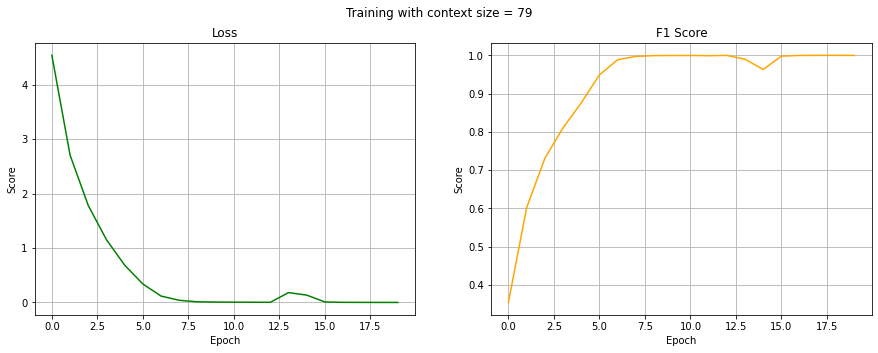

In [12]:
def looping_step(dataloader, model, optimizer, criterion, metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_losses = []
    epoch_metric_scores = []
    patience_counter = 0
    
    now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
    path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
    os.makedirs(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}")
    
    # Hyperparameters
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 50}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 50}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
        
        batch_losses, batch_metric_scores = training_step(dataloader, model, optimizer, criterion, metric, path_name=path_name)
        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))

        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))
        epoch_losses.append(epoch_loss.item())

        epoch_metric_score = torch.mean(torch.FloatTensor(batch_metric_scores))
        epoch_metric_scores.append(epoch_metric_score.item())
        
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_losses[-1] < epoch_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")                    
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_metric_scores[-1] > epoch_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 50, end="\n\n")
            f.write(f"{'=' * 50}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        metric.reset()
    
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_losses, "green")
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_metric_scores, "orange")
    ax_metric_score.grid()

    plt.savefig(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    criterion_name = "Best " + str(criterion).split('(')[0]
    metric_name = "Best " + str(metric).split('(')[0]
    
    print(f"{criterion_name.ljust(18)}: {best_loss:.4f}")
    print(f"{metric_name.ljust(18)}: {best_metric:.4f}")
    print(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.")
    print(f"{'Training date'.ljust(18)}: {now}")
    
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 50}\n")
        f.write(f"{criterion_name.ljust(18)}: {best_loss:.4f}\n")
        f.write(f"{metric_name.ljust(18)}: {best_metric:.4f}\n")
        f.write(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.\n")
        f.write(f"{'Training date'.ljust(18)}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    filename_model_params = f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/model_params.pth"
    filename_oov_embedding_dict = open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/oov_embedding_dict.pkl", "ab")
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_losses) + 1)),
            "loss": epoch_losses
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_losses.csv", index=False)
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_metric_scores) + 1)),
            "f1_score": epoch_metric_scores
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_metric_scores.csv", index=False)
    
    torch.save(best_state_dict, filename_model_params)
    pickle.dump({token : embedding for token, embedding in zip(list(labels_to_idx.keys()), model.embedding)}, filename_oov_embedding_dict)
    
    return epoch_losses, epoch_metric_scores

epoch_losses, epoch_metric_scores = looping_step(dataloader, model, optimizer, criterion, metric)

# END

In [13]:
model.embedding

array([[ 0.88485795, -3.2273695 ,  0.28837246, ..., -1.500096  ,
        -0.4721673 ,  5.962238  ],
       [-2.2189875 ,  3.4459896 , -2.0817409 , ...,  2.3434176 ,
        -4.7441225 ,  3.5739758 ],
       [-2.9355183 , -0.41798598, -1.3048999 , ...,  9.925539  ,
        -3.568224  , -6.23039   ],
       ...,
       [ 6.45844   , -1.5894524 ,  2.990764  , ...,  1.544313  ,
        -1.6937437 , -0.01078879],
       [ 0.19107032, -0.8977425 ,  5.1170073 , ..., -6.5612803 ,
         4.7654657 ,  3.7947006 ],
       [-1.7708272 , -0.09179287, -2.7237394 , ...,  3.9349575 ,
        -4.716484  , -0.2576896 ]], dtype=float32)

In [14]:
model.state_dict()

OrderedDict([('bilstm_left_context_feature.weight_ih_l0',
              tensor([[ 0.0028, -0.0497,  0.5100,  ..., -0.3477,  0.3091,  0.1202],
                      [ 0.0294, -0.0808,  0.0107,  ..., -0.0161, -0.0950, -0.0701],
                      [ 0.1427, -0.1713,  0.1106,  ..., -0.1606, -0.0752, -0.0594],
                      ...,
                      [ 0.2979, -0.0584,  0.0009,  ..., -0.1208,  0.0621, -0.1685],
                      [ 0.0495, -0.2009,  0.2793,  ..., -0.2290,  0.4574, -0.2754],
                      [ 0.2883, -0.2180,  0.0797,  ..., -0.0828,  0.3293, -0.5595]])),
             ('bilstm_left_context_feature.weight_hh_l0',
              tensor([[-0.0476, -0.2417,  0.2973,  ..., -0.3268, -0.0044, -0.2318],
                      [ 0.1909, -0.1913, -0.0052,  ...,  0.1024,  0.0999,  0.0192],
                      [-0.0827,  0.0865,  0.0017,  ..., -0.1065, -0.1961,  0.0388],
                      ...,
                      [-0.1662,  0.0515,  0.0176,  ..., -0.2628, -0.052